In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

Data taken from https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

In [2]:
image_data = pd.read_csv('data/fer2013.csv')
image_data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
image_data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

Splitting the data into training, validation and testing.

In [4]:
training_data = image_data[image_data.Usage == 'Training']
print(training_data.Usage.value_counts())
training_data.head(2)

Training    28709
Name: Usage, dtype: int64


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training


In [5]:
validation_data = image_data[image_data.Usage == 'PublicTest']
print(validation_data.Usage.value_counts())
validation_data.head(2)

PublicTest    3589
Name: Usage, dtype: int64


,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest


In [6]:
testing_data = image_data[image_data.Usage == 'PrivateTest']
print(testing_data.Usage.value_counts())
testing_data.head(2)

PrivateTest    3589
Name: Usage, dtype: int64


,emotion,pixels,Usage
32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,PrivateTest
32299,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,PrivateTest


In [7]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = training_data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
print(emotion_counts)
print("\n")
print(f"Mean of the number of values per emotion = {training_data.emotion.value_counts().mean()}")
print(f"Standard deviation over number of values per emotion = {training_data.emotion.value_counts().std()}")

    emotion  number
0     Angry    3995
1      Fear    4097
2       Sad    4830
3   Neutral    4965
4     Happy    7215
5  Surprise    3171
6    Digust     436


Mean of the number of values per emotion = 4101.285714285715
Standard deviation over number of values per emotion = 2052.7749279358186


In [8]:
import math
pix_arr = np.fromstring(training_data.pixels[0],dtype=int, sep=' ')
dim = int(math.sqrt(pix_arr.size))
print(f"length of side of the square image =  {dim}")

length of side of the square image =  48


Visualising the images

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

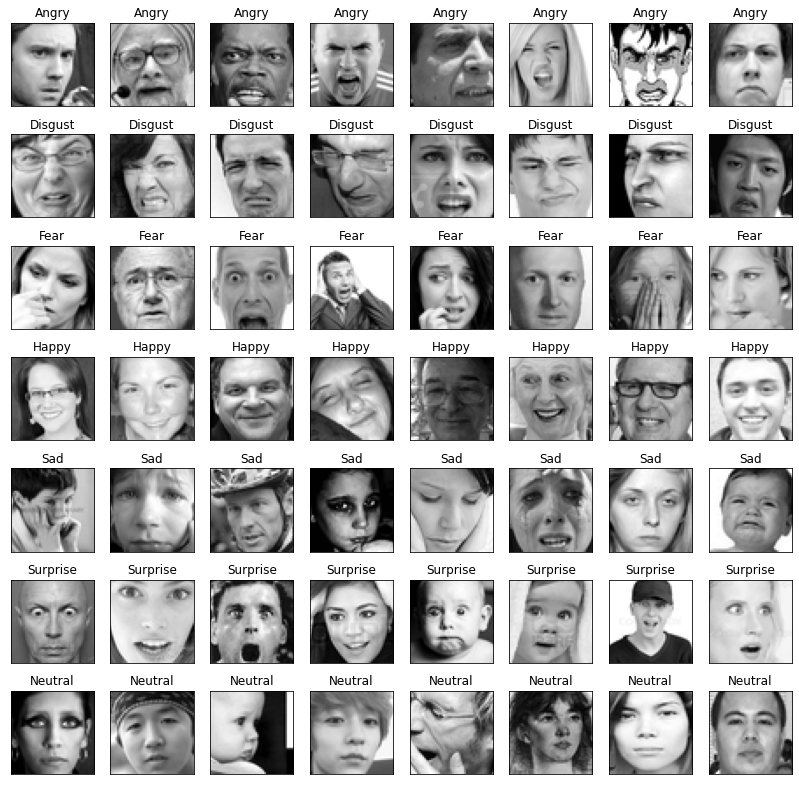

In [10]:
plt.figure(1,(14,14))

emotion_names = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

position = 1
for emotion in sorted(training_data.emotion.unique()):
    emotion_data = training_data[training_data.emotion==emotion].iloc[0:8,:]
    for j in range(8):
        img = np.fromstring(emotion_data.pixels.iloc[j],dtype=int, sep=' ').reshape(48,48)
        ax = plt.subplot(7,8,position)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_names[emotion])
        ax.imshow(img, cmap='gray')
        position+=1

In [11]:
emotion_map = {0:0, 2:2, 3:3, 4:4, 5:5, 6:1}

# Dropping the disgust samples, and then remapping '1' to Neutral
# if we do not remap, to_categorical will raise an index error.
training_data = training_data[training_data.emotion!=1]
training_data['emotion'] = training_data.emotion.map(emotion_map)

# number of classes now becomes 6
nclasses = 6 

# similarly for validation and testing data
validation_data = validation_data[validation_data.emotion!=1]
validation_data['emotion'] = validation_data.emotion.map(emotion_map)

testing_data = testing_data[testing_data.emotion!=1]
testing_data['emotion'] = testing_data.emotion.map(emotion_map)

Preparing the labels and targets arrays as required by tensorflow

In [12]:
x_train = training_data.pixels.apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(dim,dim,1))
x_train = np.stack(x_train.values)
x_train = x_train/255

In [13]:
from keras.utils import np_utils

# Because the final layer will have 6 neurons so it expects one-hot-encoded values.
y_train = np_utils.to_categorical(y=np.array(training_data.emotion), num_classes=nclasses)

In [14]:
x_valid = validation_data.pixels.apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(dim,dim,1))
x_valid = np.stack(x_valid.values)
x_valid = x_valid/255

y_valid = np_utils.to_categorical(y=np.array(validation_data.emotion), num_classes=nclasses)

Creating and training the model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix

In [24]:
# Using the Sequential model

model = Sequential([
    Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='elu', input_shape=(dim,dim,1)),
    BatchNormalization(),
    
    Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    
    Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    
    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    
    Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(nclasses, activation='softmax')
])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 32)        832       
                                                                 
 batch_normalization_10 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        51264     
                                                                 
 batch_normalization_11 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 64)      

In [26]:
# Constructing the training image generator that will augment the data

datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)                  # randomly flip images

datagen.fit(x_train)

In [27]:
# Early Stopping callback.

from keras.callbacks import EarlyStopping
es = EarlyStopping(
    monitor='val_loss',       # Quantity to be monitored.
    patience = 8,            # Number of epochs with no improvement after which training will be stopped.
    mode = 'min',             # In min mode, training will stop when the quantity monitored has stopped decreasing
    restore_best_weights=True 
)

In [28]:
# ReduceLR callback.

from keras.callbacks import ReduceLROnPlateau

lr_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', # quantity to be monitored.
    factor=0.5,             # new_lr = lr * factor
    patience=3,             # number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00005,         # lower bound on the learning rate
    verbose=1,
)

In [29]:
epochs = 20
batch_size=32

In [30]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [31]:
history = model.fit(datagen.flow(x=x_train,y=y_train,batch_size=batch_size),
          epochs=epochs, 
          validation_data=(x_valid,y_valid),
          verbose=1, 
          steps_per_epoch=x_train.shape[0] / batch_size,
          callbacks=[es, lr_reduction])

Epoch 1/20
883/883 [==============================] - 40s 44ms/step - loss: 1.7565 - accuracy: 0.2691 - val_loss: 1.7595 - val_accuracy: 0.2675 - lr: 0.0010
Epoch 2/20
883/883 [==============================] - 39s 44ms/step - loss: 1.4986 - accuracy: 0.3982 - val_loss: 1.5050 - val_accuracy: 0.4019 - lr: 0.0010
Epoch 3/20
883/883 [==============================] - 39s 44ms/step - loss: 1.3241 - accuracy: 0.4765 - val_loss: 1.4709 - val_accuracy: 0.3869 - lr: 0.0010
Epoch 4/20
883/883 [==============================] - 39s 44ms/step - loss: 1.2335 - accuracy: 0.5189 - val_loss: 1.3289 - val_accuracy: 0.4829 - lr: 0.0010
Epoch 5/20
883/883 [==============================] - 39s 44ms/step - loss: 1.1698 - accuracy: 0.5461 - val_loss: 1.3286 - val_accuracy: 0.4735 - lr: 0.0010
Epoch 6/20
883/883 [==============================] - 39s 44ms/step - loss: 1.1133 - accuracy: 0.5696 - val_loss: 1.2767 - val_accuracy: 0.5115 - lr: 0.0010
Epoch 7/20
883/883 [==============================] - 39s 

In [32]:
model.save('models/fer2013_cnn2.h5')